# NLP Lab 4: Text Classification

**Mục tiêu:** Xây dựng pipeline phân loại văn bản hoàn chỉnh, từ raw text đến trained model.

**Nội dung:**
1. Task 1: Chuẩn bị dữ liệu và xây dựng TextClassifier
2. Task 2: Huấn luyện và đánh giá với Logistic Regression (Baseline)
3. Task 3: Cải tiến với Multinomial Naive Bayes
4. Task 4: Thử nghiệm với Word2Vec features
5. Task 5: So sánh và phân tích kết quả

In [1]:
import sys
import os
import numpy as np
import pandas as pd
from typing import List, Dict

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Thêm path để import module từ src
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src')))

## Task 1: Chuẩn bị dữ liệu và xây dựng TextClassifier

### 1.1. Tải và khám phá dữ liệu
Sử dụng bộ dữ liệu Twitter Financial News Sentiment với 3 nhãn:
- 0: Bearish (tiêu cực)
- 1: Bullish (tích cực)  
- 2: Neutral (trung tính)

In [2]:
# Tải dữ liệu từ file CSV
train_df = pd.read_csv('../data/lab4/sent_train.csv')
valid_df = pd.read_csv('../data/lab4/sent_valid.csv')

print("=== Thông tin Dataset ===")
print(f"Số mẫu train: {len(train_df)}")
print(f"Số mẫu validation: {len(valid_df)}")
print(f"\nPhân bố nhãn (train):")
print(train_df['label'].value_counts().sort_index())
print(f"\nPhân bố nhãn (validation):")
print(valid_df['label'].value_counts().sort_index())

=== Thông tin Dataset ===
Số mẫu train: 9543
Số mẫu validation: 2388

Phân bố nhãn (train):
label
0    1442
1    1923
2    6178
Name: count, dtype: int64

Phân bố nhãn (validation):
label
0     347
1     475
2    1566
Name: count, dtype: int64


In [3]:
# Xem một số mẫu dữ liệu
print("=== Mẫu dữ liệu ===")
for label in [0, 1, 2]:
    label_names = {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}
    sample = train_df[train_df['label'] == label].iloc[0]
    print(f"\n[{label_names[label]}]: {sample['text'][:100]}...")

=== Mẫu dữ liệu ===

[Bearish]: $BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT...

[Bullish]: $ALTG: Dougherty & Company starts at Buy...

[Neutral]: $LB - MKM Partners puts a number on Victoria's Secret https://t.co/VSzHLqLBgE...


### 1.2. Xây dựng lớp TextClassifier

In [4]:
class TextClassifier:

    def __init__(self, vectorizer, model):
        self.vectorizer = vectorizer
        self.model = model
        self._is_fitted = False
    
    def fit(self, texts: List[str], labels: List[int]):
        # Vectorize văn bản
        X = self.vectorizer.fit_transform(texts)
        # Huấn luyện model
        self.model.fit(X, labels)
        self._is_fitted = True
        return self
    
    def predict(self, texts: List[str]) -> np.ndarray:
        if not self._is_fitted:
            raise ValueError("Model chưa được huấn luyện. Gọi fit() trước.")
        X = self.vectorizer.transform(texts)
        return self.model.predict(X)
    
    def predict_proba(self, texts: List[str]) -> np.ndarray:
        if not self._is_fitted:
            raise ValueError("Model chưa được huấn luyện. Gọi fit() trước.")
        X = self.vectorizer.transform(texts)
        return self.model.predict_proba(X)
    
    def evaluate(self, y_true: List[int], y_pred: List[int]) -> Dict[str, float]:
        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='weighted', zero_division=0
        )
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }

print("TextClassifier đã được định nghĩa!")

TextClassifier đã được định nghĩa!


### 1.3. Chuẩn bị dữ liệu cho huấn luyện

In [5]:
# Chuẩn bị dữ liệu
X_train = train_df['text'].tolist()
y_train = train_df['label'].tolist()
X_test = valid_df['text'].tolist()
y_test = valid_df['label'].tolist()

print(f"Kích thước tập train: {len(X_train)}")
print(f"Kích thước tập test: {len(X_test)}")

Kích thước tập train: 9543
Kích thước tập test: 2388


## Task 2: Huấn luyện Baseline Model (Logistic Regression + TF-IDF)

In [6]:
# Khởi tạo vectorizer và model
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,      # Giới hạn vocabulary
    ngram_range=(1, 2),     # Unigrams và bigrams
    stop_words='english'    # Loại bỏ stop words
)

lr_model = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    
)

# Khởi tạo và huấn luyện classifier
baseline_classifier = TextClassifier(tfidf_vectorizer, lr_model)
baseline_classifier.fit(X_train, y_train)

print("Baseline model (Logistic Regression + TF-IDF) đã được huấn luyện!")

Baseline model (Logistic Regression + TF-IDF) đã được huấn luyện!


In [7]:
# Dự đoán và đánh giá
y_pred_baseline = baseline_classifier.predict(X_test)
metrics_baseline = baseline_classifier.evaluate(y_test, y_pred_baseline)

print("=== Kết quả Baseline (Logistic Regression + TF-IDF) ===")
for metric, value in metrics_baseline.items():
    print(f"{metric.capitalize()}: {value:.4f}")

print("\n=== Classification Report ===")
target_names = ['Bearish (0)', 'Bullish (1)', 'Neutral (2)']
print(classification_report(y_test, y_pred_baseline, target_names=target_names, zero_division=0))

=== Kết quả Baseline (Logistic Regression + TF-IDF) ===
Accuracy: 0.8061
Precision: 0.8024
Recall: 0.8061
F1_score: 0.7887

=== Classification Report ===
              precision    recall  f1-score   support

 Bearish (0)       0.78      0.40      0.53       347
 Bullish (1)       0.78      0.60      0.68       475
 Neutral (2)       0.81      0.96      0.88      1566

    accuracy                           0.81      2388
   macro avg       0.79      0.65      0.69      2388
weighted avg       0.80      0.81      0.79      2388



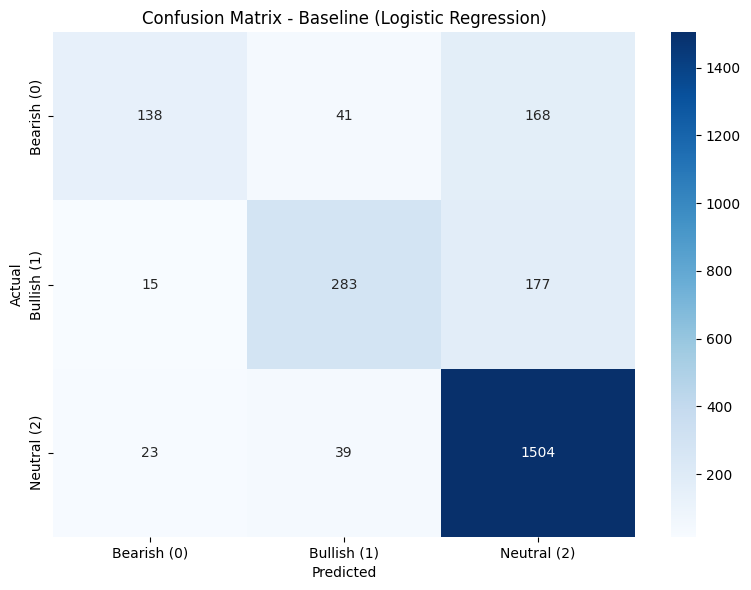

In [8]:
# Visualize Confusion Matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - Baseline (Logistic Regression)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## Task 3: Cải tiến với Multinomial Naive Bayes

In [9]:
# Khởi tạo vectorizer mới và Naive Bayes model
tfidf_vectorizer_nb = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english'
)

nb_model = MultinomialNB(alpha=0.1)  # Laplace smoothing

# Huấn luyện
nb_classifier = TextClassifier(tfidf_vectorizer_nb, nb_model)
nb_classifier.fit(X_train, y_train)

# Đánh giá
y_pred_nb = nb_classifier.predict(X_test)
metrics_nb = nb_classifier.evaluate(y_test, y_pred_nb)

print("=== Kết quả Naive Bayes ===")
for metric, value in metrics_nb.items():
    print(f"{metric.capitalize()}: {value:.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred_nb, target_names=target_names, zero_division=0))

=== Kết quả Naive Bayes ===
Accuracy: 0.8090
Precision: 0.7998
Recall: 0.8090
F1_score: 0.7986

=== Classification Report ===
              precision    recall  f1-score   support

 Bearish (0)       0.70      0.48      0.57       347
 Bullish (1)       0.75      0.62      0.68       475
 Neutral (2)       0.84      0.94      0.88      1566

    accuracy                           0.81      2388
   macro avg       0.76      0.68      0.71      2388
weighted avg       0.80      0.81      0.80      2388



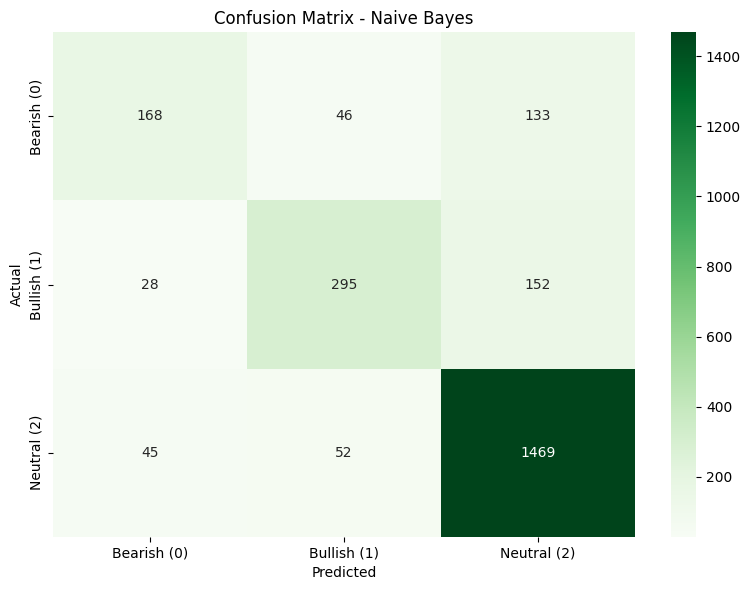

In [10]:
# Confusion Matrix cho Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## Task 4: Thử nghiệm với Word2Vec Features

In [11]:
from representations.word_embedder import WordEmbedder

# Load pre-trained Word2Vec model từ file local
print("Đang tải Word2Vec model...")
w2v_model = WordEmbedder("glove-wiki-gigaword-50")
print("Tải xong!")

Đang tải Word2Vec model...
Đang tải model 'glove-wiki-gigaword-50'... Vui lòng chờ.
Đang load ../data/glove.6B.50d.txt...
Tải model thành công.
Tải xong!


In [12]:
def text_to_w2v_vector(text: str, embedder: WordEmbedder, vector_size: int = 50) -> np.ndarray:
    words = text.lower().split()
    vectors = []
    for word in words:
        if embedder.model is not None and word in embedder.model:
            vectors.append(embedder.model[word])
    
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

def texts_to_w2v_matrix(texts: List[str], embedder: WordEmbedder, vector_size: int = 50) -> np.ndarray:
    return np.array([text_to_w2v_vector(text, embedder, vector_size) for text in texts])

# Tạo features từ Word2Vec
print("Đang tạo Word2Vec features...")
X_train_w2v = texts_to_w2v_matrix(X_train, w2v_model)
X_test_w2v = texts_to_w2v_matrix(X_test, w2v_model)
print(f"Shape của X_train_w2v: {X_train_w2v.shape}")
print(f"Shape của X_test_w2v: {X_test_w2v.shape}")

Đang tạo Word2Vec features...
Shape của X_train_w2v: (9543, 50)
Shape của X_test_w2v: (2388, 50)


In [13]:
# Huấn luyện Logistic Regression với Word2Vec features
lr_w2v = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

lr_w2v.fit(X_train_w2v, y_train)
y_pred_w2v = lr_w2v.predict(X_test_w2v)

# Đánh giá
accuracy_w2v = accuracy_score(y_test, y_pred_w2v)
precision_w2v, recall_w2v, f1_w2v, _ = precision_recall_fscore_support(
    y_test, y_pred_w2v, average='weighted', zero_division=0
)

metrics_w2v = {
    'accuracy': accuracy_w2v,
    'precision': precision_w2v,
    'recall': recall_w2v,
    'f1_score': f1_w2v
}

print("=== Kết quả Word2Vec + Logistic Regression ===")
for metric, value in metrics_w2v.items():
    print(f"{metric.capitalize()}: {value:.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred_w2v, target_names=target_names, zero_division=0))

=== Kết quả Word2Vec + Logistic Regression ===
Accuracy: 0.7136
Precision: 0.6760
Recall: 0.7136
F1_score: 0.6781

=== Classification Report ===
              precision    recall  f1-score   support

 Bearish (0)       0.46      0.21      0.29       347
 Bullish (1)       0.55      0.37      0.44       475
 Neutral (2)       0.76      0.93      0.84      1566

    accuracy                           0.71      2388
   macro avg       0.59      0.50      0.52      2388
weighted avg       0.68      0.71      0.68      2388



## Task 5: So sánh và Phân tích Kết quả

In [14]:
# Tổng hợp kết quả
results = pd.DataFrame({
    'Model': ['Logistic Regression + TF-IDF', 'Naive Bayes + TF-IDF', 'Logistic Regression + Word2Vec'],
    'Accuracy': [metrics_baseline['accuracy'], metrics_nb['accuracy'], metrics_w2v['accuracy']],
    'Precision': [metrics_baseline['precision'], metrics_nb['precision'], metrics_w2v['precision']],
    'Recall': [metrics_baseline['recall'], metrics_nb['recall'], metrics_w2v['recall']],
    'F1-Score': [metrics_baseline['f1_score'], metrics_nb['f1_score'], metrics_w2v['f1_score']]
})

print("=== Bảng So sánh Kết quả ===")
print(results.to_string(index=False))

=== Bảng So sánh Kết quả ===
                         Model  Accuracy  Precision   Recall  F1-Score
  Logistic Regression + TF-IDF  0.806114   0.802429 0.806114  0.788655
          Naive Bayes + TF-IDF  0.809045   0.799829 0.809045  0.798564
Logistic Regression + Word2Vec  0.713568   0.675965 0.713568  0.678124


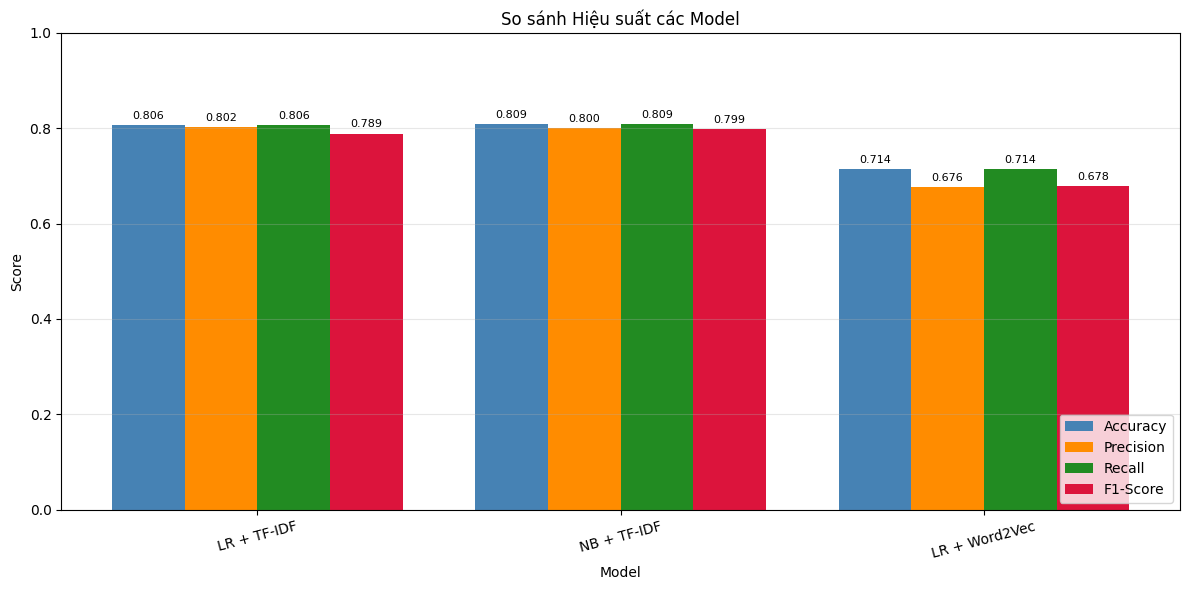

In [15]:
# Visualize so sánh
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(results['Model']))
width = 0.2

bars1 = ax.bar(x - 1.5*width, results['Accuracy'], width, label='Accuracy', color='steelblue')
bars2 = ax.bar(x - 0.5*width, results['Precision'], width, label='Precision', color='darkorange')
bars3 = ax.bar(x + 0.5*width, results['Recall'], width, label='Recall', color='forestgreen')
bars4 = ax.bar(x + 1.5*width, results['F1-Score'], width, label='F1-Score', color='crimson')

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('So sánh Hiệu suất các Model')
ax.set_xticks(x)
ax.set_xticklabels(['LR + TF-IDF', 'NB + TF-IDF', 'LR + Word2Vec'], rotation=15)
ax.legend(loc='lower right')
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

# Thêm giá trị lên bars
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

### Phân tích Kết quả

**1. Logistic Regression + TF-IDF (Baseline):**
- Đây là baseline model với hiệu suất ổn định
- TF-IDF capture được tầm quan trọng của từ trong document
- Phù hợp với bài toán phân loại văn bản ngắn (tweets)

**2. Naive Bayes + TF-IDF:**
- Naive Bayes thường nhanh hơn và hoạt động tốt với dữ liệu text
- Giả định độc lập giữa các features có thể không phù hợp với ngữ cảnh thực tế

**3. Word2Vec + Logistic Regression:**
- Word2Vec capture được semantic meaning của từ
- Mean pooling có thể mất thông tin về thứ tự từ
- Hiệu quả phụ thuộc vào chất lượng pre-trained embeddings